In [4]:
import pandas as pd
import numpy as np
from bff_processor.Systogram import Systogram
from bff_processor.bff_meta import *
from bff_processor.sig_op_func import *
from bff_processor.bff_cuts import bff_1, bff_2, reg_filter
import os
import re
from time import perf_counter
import boost_histogram as bh

In [5]:
def make_dict(name, files):
    t_dict = {}
    t_dict['data'] = files
    for reg in all_reg:
        t_dict[reg] = Systogram(bh.axis.Regular(*bin_meta), storage=bh.storage.Weight(), metadata='DiLepMass ({}/{})'.format(name,reg))
    return t_dict

In [58]:
column, bin_meta = columns[0]
column, bin_meta
bin_meta = [139, 110, 800]

In [88]:
era = 2016
regex_select = "tw_{}.+\.csv".format(era)
files = [x for x in os.listdir('data') if re.match(regex_select, x)]
DY = [x for x in files if re.match('.+ZTo(?:Mu|EE).+', x)]
ST = [x for x in files if re.match('.+top.csv', x)]
VB = [x for x in files if re.match('.+mc_(?:ww|wz|zz)', x)]
TT = [x for x in files if re.match('.+ttbar', x)]
BFF = [x for x in files if re.match('.+BFFZp', x)]
data = [x for x in files if re.match('.+_data_', x)]
assert len(files) == len(DY+ST+TT+VB+data+BFF), "duplicate or uncaught file"

In [89]:
DY_dict = make_dict('DY', DY)
ST_dict = make_dict('ST', ST)
TT_dict = make_dict('TT', TT)
VB_dict = make_dict('VB', VB)
data_dict = make_dict('data', data)
bff_list = []
for bff in BFF:
    name = re.findall('tw_[0-9]+_(.+).csv',bff)[0]
    bff_list.append(make_dict(name, [bff]))

In [90]:
print(data_dict)

{'data': ['tw_2016_data_el.csv', 'tw_2016_data_mu.csv'], 'SR1': Systogram(Regular(139, 110, 800), storage=Weight()) # Sum: WeightedSum(value=0, variance=0), 'SR2': Systogram(Regular(139, 110, 800), storage=Weight()) # Sum: WeightedSum(value=0, variance=0), 'CR10': Systogram(Regular(139, 110, 800), storage=Weight()) # Sum: WeightedSum(value=0, variance=0), 'CR20': Systogram(Regular(139, 110, 800), storage=Weight()) # Sum: WeightedSum(value=0, variance=0), 'CR13': Systogram(Regular(139, 110, 800), storage=Weight()) # Sum: WeightedSum(value=0, variance=0), 'CR23': Systogram(Regular(139, 110, 800), storage=Weight()) # Sum: WeightedSum(value=0, variance=0), 'CR14': Systogram(Regular(139, 110, 800), storage=Weight()) # Sum: WeightedSum(value=0, variance=0), 'CR24': Systogram(Regular(139, 110, 800), storage=Weight()) # Sum: WeightedSum(value=0, variance=0)}


In [91]:
def region_bff_filter(df, reg, var):
    nJets = re.findall(r'(?:SR|CR)(\d)', reg)[0]
    if nJets == '1': 
        bff_func = bff_1
    else: 
        bff_func = bff_2
    return bff_func(reg_filter(df, '{}_{}'.format(reg, var)), var)

In [92]:
def process_sample(df, hist_dict, bff_cv=BFF_cut_values, ismc=0, blinded=True, column='DiLepMass'):
    start = perf_counter()
    import re
    for reg in all_reg:
        rdf = region_bff_filter(df, reg, 'nom')
        #remove blinded data
        if  (not ismc) and blinded and ('SR' in reg): continue
        hist_dict[reg].fill(rdf[column], weight=rdf['Weight'])
        if ismc:
            for wup, wdown in weights:
                w = wup.replace('Up','')
                hist_dict[reg].get_sys(w)['up'].fill(rdf[column], weight=rdf[wup])
                hist_dict[reg].get_sys(w)['down'].fill(rdf[column], weight=rdf[wdown])    
            for jvup, jvdown in jet_variations:
                jv = jvup.replace('Up','')
                rdf = region_bff_filter(df, reg, jvup)
                hist_dict[reg].get_sys(jv)['up'].fill(rdf[column], weight=rdf['Weight'])
                reg_jv = '{}_{}'.format(reg, jvup)
                rdf = region_bff_filter(df, reg, jvup)
                hist_dict[reg].get_sys(jv)['down'].fill(rdf[column], weight=rdf['Weight'])
    print(perf_counter()-start)
    return hist_dict

def process_all_sample(s_dict, **kwargs):
    for files in s_dict['data']:
        print(files)
        df = pd.read_csv('data/'+files)
        process_sample(df, s_dict, **kwargs)

In [93]:
process_all_sample(DY_dict,ismc=1)
process_all_sample(ST_dict,ismc=1)
process_all_sample(TT_dict,ismc=1)
process_all_sample(VB_dict,ismc=1)
process_all_sample(data_dict,ismc=0)
for bff in bff_list:
    process_all_sample(bff,ismc=1)

tw_2016_ZToMuMu_M_400_800.csv
0.1750415790011175
tw_2016_ZToMuMu_M_200_400.csv
0.2002676080010133
tw_2016_ZToEE_M_400_800.csv
0.18492015000083484
tw_2016_ZToEE_M_200_400.csv
0.17896456499875057
tw_2016_ZToMuMu_M_120_200.csv
0.1391911690006964
tw_2016_ZToEE_M_800_1400.csv
0.16486633599561173
tw_2016_ZToMuMu_M_50_120.csv
0.11745319699548418
tw_2016_ZToMuMu_M_800_1400.csv
0.18686248299491126
tw_2016_ZToEE_M_50_120.csv
0.11477119700430194
tw_2016_ZToEE_M_120_200.csv
0.15928409499611007
tw_2016_mc_stop.csv
0.2089539180014981
tw_2016_mc_santitop.csv
0.22467514099844266
tw_2016_mc_ttbar.csv
2.7014882049988955
tw_2016_mc_ww.csv
0.1197180470044259
tw_2016_mc_zz.csv
0.12100191100034863
tw_2016_mc_wz.csv
0.12802349699632032
tw_2016_data_el.csv
0.0401015230017947
tw_2016_data_mu.csv
0.061594032995344605
tw_2016_BFFZprimeToMuMu_M_500_dbs0p04.csv
0.5026250840019202
tw_2016_BFFZprimeToMuMu_M_250_dbs0p04.csv
0.45269576200371375
tw_2016_BFFZprimeToMuMu_M_200_dbs0p04.csv
0.370310143000097
tw_2016_BFFZpr

In [94]:
processed_stuff = {
"DY_dict":DY_dict,
"ST_dict":ST_dict,
"TT_dict":TT_dict,
"VB_dict":VB_dict,
"data_dict":data_dict,
"bff_list":bff_list,
}
import pickle
outname="{}_functional_plotter.pkl".format(era)
with open(outname,'wb') as f:
    pickle.dump(processed_stuff, f)

In [99]:
reg = 'SR1'
data_nom,data_err  = data_dict[reg].values(),  data_dict[reg].variances()
center = DY_dict[reg].axes[0].centers
DY_nom, DY_up, DY_down = DY_dict[reg].nom_std_arrays()
TT_nom, TT_up, TT_down = TT_dict[reg].nom_std_arrays()
ST_nom, ST_up, ST_down = ST_dict[reg].nom_std_arrays()
VB_nom, VB_up, VB_down = VB_dict[reg].values(), VB_dict[reg].variances()**.5, -VB_dict[reg].variances()**.5
bff_plt_list = [x[reg].nom_std_arrays() for x in  bff_list]


(0.1, 100000.0)

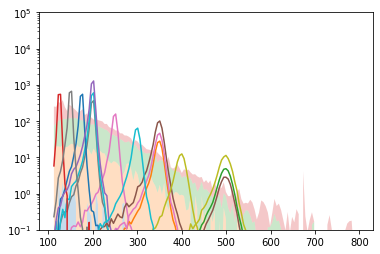

In [100]:
import matplotlib.pyplot as plt
plt.stackplot(center, [VB_nom,ST_nom,TT_nom,DY_nom], alpha=.25)
plt.errorbar(center, data_nom)
for nom,up, down in bff_plt_list:
    plt.plot(center, nom)
#plt.fill_between(center, up, down, alpha=.25)
plt.yscale('log')
plt.ylim(bottom=1e-1, top=1e5)

(0.1, 100000.0)

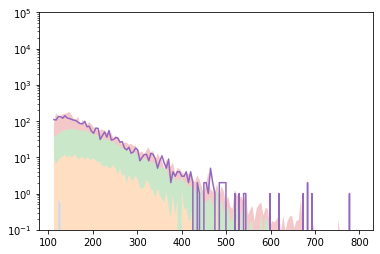

In [98]:
reg = 'CR13'
data_nom,data_err  = data_dict[reg].values(),  data_dict[reg].variances()
center = DY_dict[reg].axes[0].centers
DY_nom, DY_up, DY_down = DY_dict[reg].nom_std_arrays()
TT_nom, TT_up, TT_down = TT_dict[reg].nom_std_arrays()
ST_nom, ST_up, ST_down = ST_dict[reg].nom_std_arrays()
VB_nom, VB_up, VB_down = VB_dict[reg].values(), VB_dict[reg].variances()**.5, -VB_dict[reg].variances()**.5
bff_plt_list = [x[reg].nom_std_arrays() for x in  bff_list]

import matplotlib.pyplot as plt
plt.stackplot(center, [VB_nom,ST_nom,TT_nom,DY_nom], alpha=.25)
plt.errorbar(center, data_nom)
for nom,up, down in bff_plt_list:
    plt.plot(center, nom)
#plt.fill_between(center, up, down, alpha=.25)
plt.yscale('log')
plt.ylim(bottom=1e-1, top=1e5)

In [78]:
outname="{}_functional_plotter.pkl".format(era)
with open(outname,'rb') as f:
    processed_stuff= pickle.load(f)

In [37]:
processed_stuff['bff_list'][0]['SR1'].get_sys('Weight_Pu')[2].values()

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.62147258e-03,
       3.21394553e-02, 1.29866403e-02, 7.38045510e-03, 1.38778159e-02,
       7.81145276e-03, 1.38216397e-02, 2.61909232e-02, 3.07235208e-02,
       3.52951168e-02, 8.02079257e-02, 3.13850091e-02, 6.82895169e-02,
       1.59495715e-01, 5.07821356e-02, 1.46685745e-01, 1.79943498e-01,
       1.56426845e-01, 1.89957756e-01, 2.11197133e-01, 2.17842545e-01,
       3.38716024e-01, 3.12997145e-01, 5.08746838e-01, 5.63844175e-01,
       7.10714157e-01, 9.22822389e-01, 1.22668587e+00, 1.54601837e+00,
       2.44920544e+00, 3.70012574e+00, 6.09536825e+00, 9.94835929e+00,
       2.01477294e+01, 5.79628829e+01, 1.15744742e+02, 1.03297793e+02,
       4.21074255e+01, 1.03576906e+01, 2.88490195e+00, 9.44472646e-01,
       4.50040936e-01, 2.43023644e-01, 1.18231859e-01, 1.60153304e-01,
       4.61024289e-02, 1.72514753e-02, 5.13428244e-03, 2.86231185e-02,
       0.00000000e+00, 3.39225048e-03, 0.00000000e+00, 8.01685333e-03,
      

In [36]:
processed_stuff['bff_list'][0]['SR1'].values()

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.25486185e-03,
       3.37507936e-02, 1.04343856e-02, 7.02543788e-03, 1.46326776e-02,
       7.22252612e-03, 1.41045292e-02, 2.79946402e-02, 3.31522172e-02,
       3.49835427e-02, 7.98940316e-02, 3.08462592e-02, 6.70466027e-02,
       1.51554756e-01, 5.24552846e-02, 1.42774219e-01, 1.77001513e-01,
       1.51178212e-01, 1.89975748e-01, 2.13676695e-01, 2.13209422e-01,
       3.28130347e-01, 3.25779939e-01, 4.87290194e-01, 5.45602418e-01,
       6.85910315e-01, 8.95889699e-01, 1.19654019e+00, 1.54127503e+00,
       2.39273147e+00, 3.65093063e+00, 6.01484281e+00, 9.81996763e+00,
       1.99478451e+01, 5.72179141e+01, 1.14291626e+02, 1.01658146e+02,
       4.16654777e+01, 1.02778401e+01, 2.84748108e+00, 9.34857310e-01,
       4.69458053e-01, 2.39524365e-01, 1.24354656e-01, 1.48465312e-01,
       5.03054307e-02, 1.62358099e-02, 6.27168758e-03, 3.19379541e-02,
       0.00000000e+00, 4.87050740e-03, 0.00000000e+00, 1.29229028e-02,
      

In [171]:
def fit_boost(bhist, sv_mult=8, **kwargs):
    import uncertainties
    centers = bhist.axes[0].centers
    #starting 
    bsum = bhist.sum().value*sv_mult
    p0 = [bsum,.5,90,90]
    popt, pcov = curve_fit(log_norm, bhist.axes[0].centers, bhist.values(), p0=p0, bounds=(-100,[np.inf,np.inf,100,np.inf]), **kwargs)
    popt_corr = uncertainties.correlated_values(popt, pcov)
    return popt_corr


def plot_unc(ax,x, yunp, color='black', numer = [],  **kwargs):
    y_nom, y_unc = unzip_unp(yunp)
    if len(numer)==0:
        ax.plot(x, y_nom, color=color, **kwargs)
        ax.fill_between(x, y_nom+y_unc, y_nom-y_unc, color=color, alpha=.25)
    else:
        y_nom = y_nom/numer
        y_unc = y_unc/numer
        ax.plot(x, y_nom, color=color, **kwargs)
        ax.fill_between(x, y_nom+y_unc, y_nom-y_unc, color=color, alpha=.25)

In [172]:
import boost_histogram as bh
from scipy.optimize import curve_fit

In [173]:
from bff_processor.utils import make_view, ratio_plot_template, nratio_plot_template, log_norm, log_norm_unp, unzip_unp

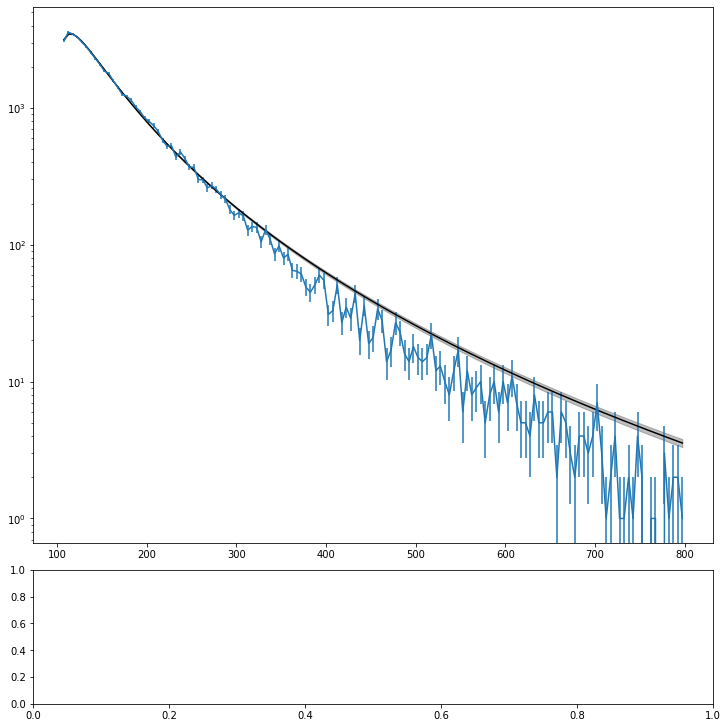

In [174]:
data_fit = fit_boost(data_dict[reg]) #fit_boost(bhist[0], sigma = bhist[0].variances()**.5, absolute_sigma=True)
data_yunp = log_norm_unp(center, *data_fit)
fig, top, bottom = ratio_plot_template( figsize=[10,10])
plot_unc(top,center, data_yunp)
top.errorbar(center, data_nom, yerr=data_err**.5)
top.set_yscale('log')

In [175]:
data_fit

(674719.0977862583+/-2751.6849619897603,
 0.9523887678522015+/-0.010499030070414172,
 94.11270276244569+/-0.5296922369977327,
 50.792073560576995+/-0.3093717444974898)

In [176]:
import zfit
from zfit import z

In [177]:
def log_norm(x, norm, sigma, theta, mean):
    return norm/((x-theta)*sigma*2*3.14159)*np.exp(-(np.log((x-theta)/mean))**2/(2*sigma**2))
from math import pi
class LogNormPDF(zfit.pdf.ZPDF):
    """1-dimensional PDF implementing the exp(alpha * x) shape."""
    _PARAMS = ['sigma', 'theta', 'mean']  # specify which parameters to take

    def _unnormalized_pdf(self, x):  # implement function
        data = z.unstack_x(x)
        sigma = self.params['sigma']
        theta = self.params['theta']
        mean = self.params['mean']
        return 1./((data-theta)*sigma*2*pi)*z.exp(-(z.numpy.log((data-theta)/mean))**2/(2*sigma**2))

In [ ]:
class LogNormPDF_variable_mean(zfit.pdf.ZPDF):
    """1-dimensional PDF implementing the exp(alpha * x) shape."""
    _PARAMS = ['sigma', 'theta', 'mean']  # specify which parameters to take

    def _unnormalized_pdf(self, x):  # implement function
        data = z.unstack_x(x)
        sigma = self.params['sigma']
        theta = self.params['theta']
        mean = self.params['mean']
        
        return 1./((data-theta)*sigma*2*pi)*z.exp(-(z.numpy.log((data-theta)/mean))**2/(2*sigma**2))

In [282]:
obs = zfit.Space("obs1", limits=(105, 120))
custom_pdf = LogNormPDF(obs=obs, sigma=.92, theta=92, mean=51)

In [283]:
integral = custom_pdf.integrate(limits=(105, 800))
sample = custom_pdf.sample(n=10000)
prob = custom_pdf.pdf(sample)

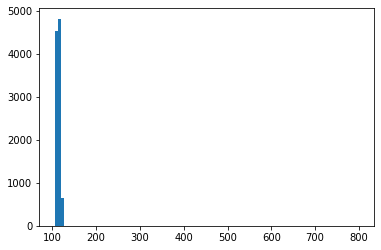

In [284]:
import matplotlib.pyplot as plt
x = plt.hist(sample.to_pandas(), bins=np.linspace(105,800,100))
#plt.yscale('log')

In [285]:
from bff_processor.data_tools import make_df

In [286]:
# create the model
#sigma    = zfit.Parameter("sigma"   , .8, 0, 1.5)
#theta = zfit.Parameter("theta", 90,  0, 100)
#mean = zfit.Parameter("mean", 51,  0, 800)
lognorm = LogNormPDF(obs=obs, sigma=sigma, theta=theta, mean=mean)

In [287]:
data_dict['data']

['tw_2018_data_mu.csv', 'tw_2018_data_el.csv']

In [288]:
# load the data

data_df = make_df(['data/'+ x for x in data_dict['data']])
data_np = region_bff_filter(data_df, reg, 'nom')['DiLepMass'].to_numpy()
data = zfit.Data.from_numpy(obs=obs, array=data_np)

1143603.869929

In [289]:
# build the loss
nll = zfit.loss.UnbinnedNLL(model=lognorm, data=data)

# minimize
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll)

# calculate errors
param_errors = result.hesse()

In [290]:
param_errors

{<zfit.Parameter 'mean' floating=True value=58.88>: {'error': 6.156174553405752,
  'cl': 0.68268949},
 <zfit.Parameter 'sigma' floating=True value=0.2763>: {'error': 0.05112597055312727,
  'cl': 0.68268949},
 <zfit.Parameter 'theta' floating=True value=60.04>: {'error': 6.6580574901943175,
  'cl': 0.68268949}}

In [291]:
result.values

[58.87800953303937, 0.2762844895717359, 60.0445579810834]

In [292]:
lognorm.params

OrderedDict([('mean', <zfit.Parameter 'mean' floating=True value=58.88>),
             ('sigma', <zfit.Parameter 'sigma' floating=True value=0.2763>),
             ('theta', <zfit.Parameter 'theta' floating=True value=60.04>)])

In [293]:
x = np.linspace(105,800,100)

131580.3445544883

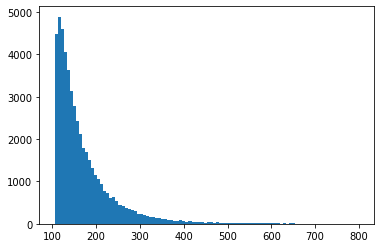

In [294]:
y = lognorm.pdf(x).numpy()
integral = lognorm.normalization([105,800]).numpy()[0]
data_y = plt.hist(data_np, bins=np.linspace(105,800,101))
norm = data_df['Weight'].sum()*integral
norm

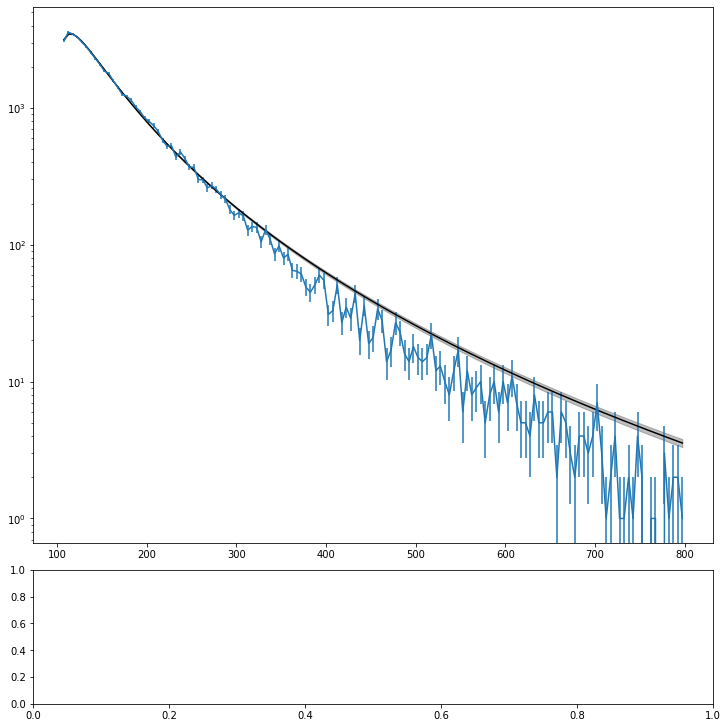

In [295]:
data_fit = fit_boost(data_dict[reg]) #fit_boost(bhist[0], sigma = bhist[0].variances()**.5, absolute_sigma=True)
data_yunp = log_norm_unp(center, *data_fit)
fig, top, bottom = ratio_plot_template( figsize=[10,10])
plot_unc(top,center, data_yunp)
top.errorbar(center, data_nom, yerr=data_err**.5)
top.set_yscale('log')

In [308]:
y = lognorm.pdf(np.linspace(105,200,100)).numpy()

In [309]:
lognorm.params

OrderedDict([('mean', <zfit.Parameter 'mean' floating=True value=58.88>),
             ('sigma', <zfit.Parameter 'sigma' floating=True value=0.2763>),
             ('theta', <zfit.Parameter 'theta' floating=True value=60.04>)])

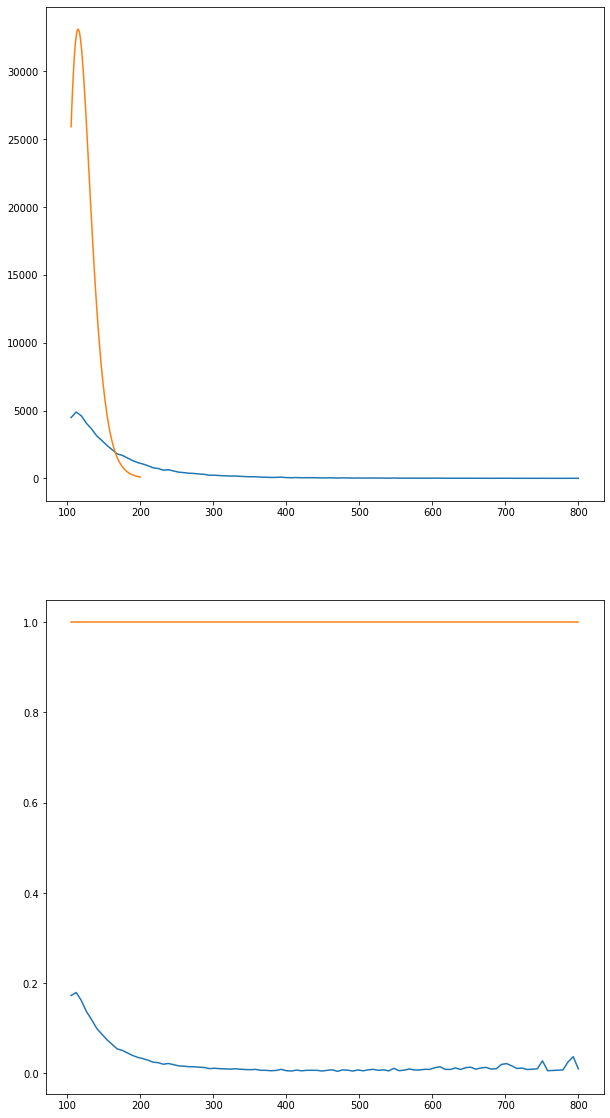

In [312]:
fig, ax = plt.subplots(2,figsize=[10,20])
ax[0].plot(x,data_y[0])
y_scaled = y*np.sum(data.numpy())/np.sum(y)
ax[0].plot(np.linspace(105,200,100),y_scaled)
#ax[0].set_yscale('log')
ax[1].plot(x, data_y[0]/y_scaled)
ax[1].plot(x, np.full(len(x), 1))